
### Models: Sentence Sentiment Classification

In [1]:
!pip install -q transformers

     |████████████████████████████████| 3.1 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 70.0 MB/s 
     |████████████████████████████████| 3.3 MB 79.1 MB/s 
     |████████████████████████████████| 61 kB 461 kB/s 
     |████████████████████████████████| 596 kB 66.5 MB/s 


[Transformers library doc](https://huggingface.co/transformers/)

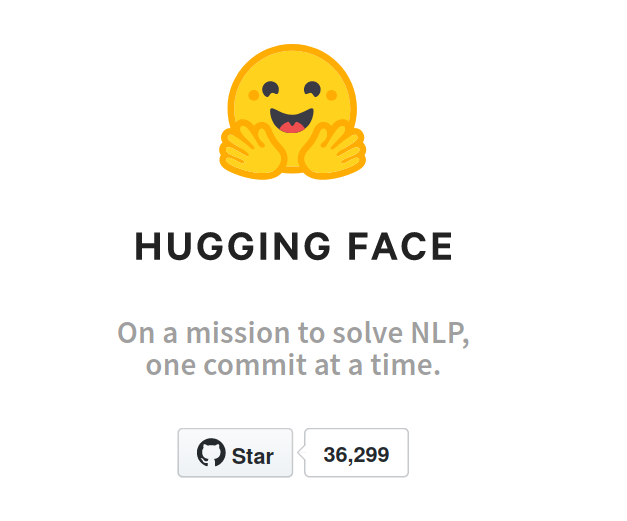

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
from transformers import get_linear_schedule_with_warmup
from transformers import logging
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
logging.set_verbosity_error()
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})

%matplotlib inline
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd drive/MyDrive/Huawei/

/content/drive/MyDrive/Huawei


### Importing the dataset

In [6]:
# Read toxic tweets
df = pd.read_csv('cleaned_train.csv')
print(df.shape)
df.head()

(34566, 3)


,id,comment_text,toxicity
0,0,fuck self righteous creep,3
1,1,stop stop goddam vandalism hell pay,2
2,2,agree rt shortcomings certainly breath fresh a...,0
3,3,would like verfiability link http waytooloud c...,0
4,4,think consensus one certain followed posting h...,0


### Using BERT for text classification.

Let's now load a pre-trained BERT model. 

In [10]:
# For DistilBERT, Load pretrained model/tokenizer:

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [11]:
# Look at the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [9]:
from termcolor import colored

colors = ['red', 'green', 'blue', 'yellow']

def model_structure(layer, margin=0, item_color=0):
    for name, next_layer in layer.named_children():

        next = (0 if not list(next_layer.named_children()) else 1)
        print(colored(' ' * margin + name, colors[item_color]) + ':' * next)
        model_structure(next_layer, margin + len(name) + 2, (item_color + 1) % 4)

model_structure(model)

embeddings:
            word_embeddings
            position_embeddings
            LayerNorm
            dropout
transformer:
             layer:
                    0:
                       attention:
                                  dropout
                                  q_lin
                                  k_lin
                                  v_lin
                                  out_lin
                       sa_layer_norm
                       ffn:
                            dropout
                            lin1
                            lin2
                       output_layer_norm
                    1:
                       attention:
                                  dropout
                                  q_lin
                                  k_lin
                                  v_lin
                                  out_lin
                       sa_layer_norm
                       ffn:
                            dropout
                      

### Preparing the dataset

In [12]:
from torch.utils.data import Dataset, random_split

class TweetDataset(Dataset):
    def __init__(self, dataset, tokenizer, labels=None, mode='train'):
        self.dataset = dataset
        self.mode = mode
        # tokenized sentences
        self.tokenized = dataset.apply(lambda x: tokenizer.encode(x, truncation=True, max_length=250, padding="max_length", add_special_tokens=True))
        if self.mode == 'train':
            self.labels = labels
    def __getitem__(self, idx):
        if self.mode == 'train':
            return {"tokenized": self.tokenized[idx], "label": self.labels[idx]}
        else:
            return {"tokenized": self.tokenized[idx]}

    def __len__(self):
        return len(self.dataset)
dataset = TweetDataset(df.iloc[:, 1], tokenizer, labels=df.iloc[:, 2])


train_size, val_size = int(.9 * len(dataset)), int(.05 * len(dataset))
torch.manual_seed(2) 
train_data, valid_data, test_data = random_split(dataset, [train_size, val_size, len(dataset) - train_size - val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 31109
Number of validation examples: 1728
Number of testing examples: 1729


In [13]:
set(df.iloc[:,2]) # labels

{0, 1, 2, 3, 4, 5}

In [14]:
from torch.utils.data import Sampler

class ReviewsSampler(Sampler):
    def __init__(self, subset, batch_size=32):
        self.batch_size = batch_size
        self.subset = subset

        self.indices = subset.indices
        # tokenized for our data
        self.tokenized = np.array(subset.dataset.tokenized)[self.indices]

    def __iter__(self):

        batch_idx = []
        # index in sorted data
        for index in np.argsort(list(map(len, self.tokenized))):
            batch_idx.append(index)
            if len(batch_idx) == self.batch_size:
                yield batch_idx
                batch_idx = []

        if len(batch_idx) > 0:
            yield batch_idx

    def __len__(self):
        return len(self.subset)

In [15]:
from torch.utils.data import DataLoader

def get_padded(values):
    tokenized = [tokenizer.encode(value, add_special_tokens=True) for value in values]
    
    max_len = 200
    for value in tokenized:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [0]*(max_len-len(value)) for value in tokenized])
    
    return padded 

def collate_fn(batch):

    inputs = []
    labels = []
    for elem in batch:
        inputs.append(elem['tokenized'])
        labels.append(elem['label'])
    inputs = get_padded(inputs)  # padded inputs
    padded = np.array(inputs)  
    attention_mask = np.where(padded != 0, 1, 0) 
    

    return {"inputs": torch.tensor(inputs), "labels": torch.FloatTensor(labels), 'attention_mask' : torch.tensor(attention_mask)}

train_loader = DataLoader(train_data, batch_sampler=ReviewsSampler(train_data), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=ReviewsSampler(valid_data), collate_fn=collate_fn) 
test_loader = DataLoader(test_data, batch_sampler=ReviewsSampler(test_data), collate_fn=collate_fn) 

In [16]:
next(iter(train_loader)).keys()

dict_keys(['inputs', 'labels', 'attention_mask'])

### Baseline

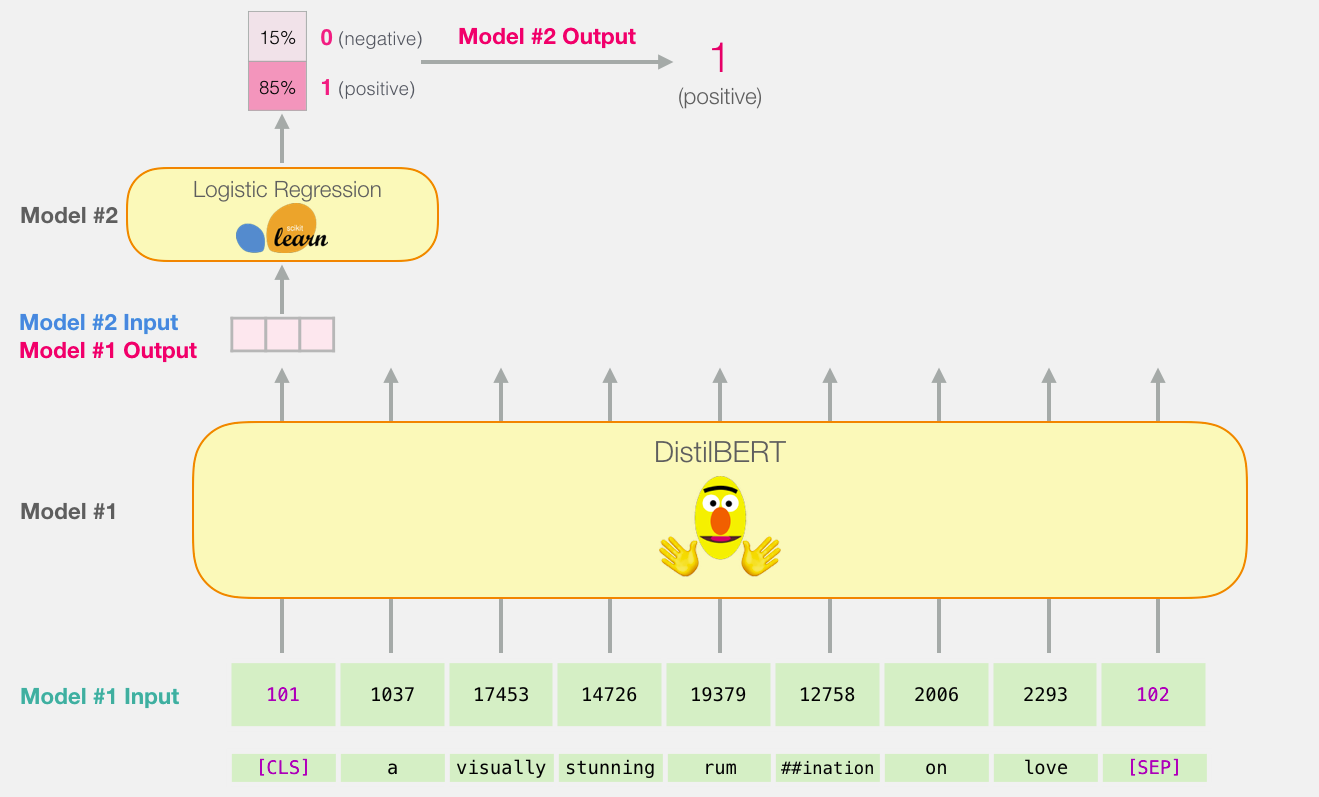

In [17]:
from tqdm.notebook import tqdm

def get_xy(loader):
    features = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(loader):
            
            inputs = batch["inputs"].to(device)
            attention_masks = batch["attention_mask"].to(device)
            label = batch["labels"].cpu()
            output = model(inputs, attention_masks)
            
            features.append(torch.tensor(output.last_hidden_state).cpu()) # last_hidden_state[:, 0, :]
            labels.append(label)
    features = torch.cat([elem[:, 0, :] for elem in features], dim=0).numpy()
    labels = torch.cat(labels, dim=0)
    
    return features, labels

In [18]:
len(train_loader)


31109

In [20]:
train_features, train_labels = get_xy(train_loader)
valid_features, valid_labels = get_xy(valid_loader)
test_features, test_labels = get_xy(test_loader)

  0%|          | 0/31109 [00:00<?, ?it/s]

  0%|          | 0/1728 [00:00<?, ?it/s]

  0%|          | 0/1729 [00:00<?, ?it/s]

In [21]:
lr_clf = LogisticRegression(multi_class='multinomial')
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.6072874493927125

In [22]:
parameters = {'C': np.linspace(0.0001, 10, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scores: ', grid_search.best_score_)

best parameters:  {'C': 3.157963157894737}
best scores:  0.6264742749010505


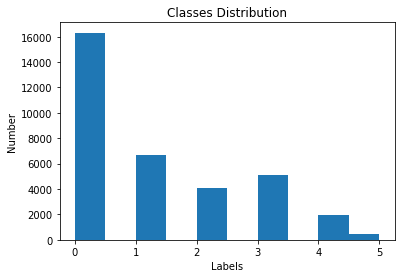

In [14]:
plt.hist(df.toxicity)
plt.xlabel('Labels')
plt.ylabel('Number')
plt.title('Classes Distribution')
plt.show()

In [19]:
test = pd.read_csv('data/test.csv')
test

,id,comment_text
0,34647,oh that great repository of free cultural work...
1,34648,my rfa with apologies for the impersonal awb ...
2,34649,it looks like a number of articles you created...
3,34650,oh but i see you ve been block for other s...
4,34651,accord of the discussion in mariah carey compo...
...,...,...
9189,43836,atat rk you cannot escape atat rk s racial s...
9190,43837,irresponsible dumheads each and every image h...
9191,43838,i agrre with above and i checked and in shia s...
9192,43839,i think there should be some form of screening...


In [20]:
def get_test(loader):
    features = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(loader):
            
            inputs = batch["inputs"].to(device)
            attention_masks = batch["attention_mask"].to(device)
            output = model(inputs, attention_masks)
            
            features.append(torch.tensor(output.last_hidden_state).cpu()) # last_hidden_state[:, 0, :]
    features = torch.cat([elem[:, 0, :] for elem in features], dim=0).numpy()
    
    return features 

def test_collate_fn(batch):

    inputs = []
    for elem in batch:
        inputs.append(elem['tokenized'])
    
    inputs = get_padded(inputs)  # padded inputs
    padded = np.array(inputs)  
    attention_mask = np.where(padded != 0, 1, 0) 
    

    return {"inputs": torch.tensor(inputs), 'attention_mask' : torch.tensor(attention_mask)}
check_dataset = TweetDataset(test.iloc[:, 1], tokenizer, labels=None, mode='test') 
check_data, _ = random_split(check_dataset, [len(check_dataset), 0]) #Subset
t_loader = DataLoader(check_data, batch_sampler=ReviewsSampler(check_data), collate_fn=test_collate_fn)
 
t_features = get_test(t_loader)

  0%|          | 0/9194 [00:00<?, ?it/s]

In [27]:
log_reg_predictions = lr_clf.predict(t_features)

In [32]:
log_reg_predictions = [int(i) for i in log_reg_predictions]

In [ ]:
log_reg_predictions

In [34]:
sub = pd.read_csv('submission.csv')
sub['prediction'] = log_reg_predictions
sub.to_csv('submission_logreg.csv', index=False)

### Fine-Tuning BERT

Define the model

In [22]:
from torch import nn

class BertClassifier(nn.Module):
    def __init__(self, pretrained_model, dropout=0.5):
        super().__init__()

        self.bert = pretrained_model
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512, 6)
    def forward(self, inputs, attention_mask):
        
      
        outputs = self.bert(inputs, attention_mask)
        output = self.fc1(outputs.last_hidden_state[:,0,:]) # last-layer hidden-state 
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        
        return output

In [28]:
import torch.optim as optim


model = model_class.from_pretrained(pretrained_weights).to(device)
bert_clf = BertClassifier(model).to(device)

batch_size = 64
lr = 2e-5 
optimizer = optim.Adam(bert_clf.parameters(), lr=lr)
weights = torch.Tensor(class_weight.compute_class_weight('balanced', classes=np.unique(df["toxicity"]), y=df["toxicity"])).type(torch.float32)

criterion = nn.CrossEntropyLoss(weight=weights.to(device))



In [29]:
def train(model, iterator, optimizer, scheduler, criterion, clip, train_history=None, valid_history=None):
    model.train()
    train_acc = 0
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        optimizer.zero_grad()

        word_tokens = batch["inputs"].to(device)
        mask_attentions = batch["attention_mask"].to(device)
        labels = torch.tensor(batch["labels"], dtype=torch.long).to(device) 

        output = model(inputs=word_tokens, attention_mask=mask_attentions)
        scores = torch.argmax(output, dim=1)
        loss = criterion(output, labels)

        loss.backward()
        train_acc += (scores==labels).sum()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        del batch
    return epoch_loss / (i + 1), train_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    epoch_loss = 0
    history = []
    val_acc = 0
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            word_tokens = batch["inputs"].to(device)
            mask_attentions = batch["attention_mask"].to(device)
            labels = torch.tensor(batch["labels"], dtype=torch.long).to(device)
            output = model(inputs=word_tokens, attention_mask=mask_attentions)
            scores = torch.argmax(output, dim=1)
            loss = criterion(output, labels)
            epoch_loss += loss.item()
            val_acc += (scores==labels).sum()
            del batch 
    return epoch_loss / (i + 1), val_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

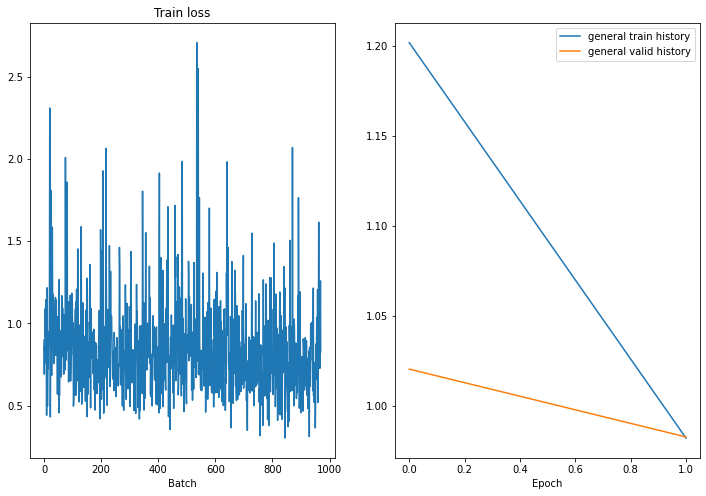

Epoch: 03 | Time: 6m 55s
	Train Loss: 0.840 | Train PPL:   2.317 | Train.Acc: 0.728
	 Val. Loss: 1.035 |  Val. PPL:   2.814 | Val.Acc: 0.669


In [30]:
train_history = []
valid_history = []

N_EPOCHS = 3
CLIP = 1.0
total_steps = len(train_data) * N_EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 2, 
                                            num_training_steps = total_steps)

best_valid_loss = float('inf')


for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(bert_clf, train_loader, optimizer, scheduler, criterion, CLIP, train_history, valid_history)
    valid_loss, val_acc = evaluate(bert_clf, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_clf.state_dict(), 'best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Train.Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} | Val.Acc: {val_acc:.3f}')

In [31]:
best_model = BertClassifier(model).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))

pred_labels = []
true_labels = []

best_model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):

        word_tokens = batch["inputs"].to(device)
        mask_attentions = batch["attention_mask"].to(device)
        labels = batch["labels"]
        output = best_model(inputs=word_tokens, attention_mask=mask_attentions)
      
        scores = torch.argmax(output, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(scores.cpu().numpy())


0it [00:00, ?it/s]

In [54]:
from sklearn.metrics import accuracy_score

BertClassifier_accuracy_score = accuracy_score(true_labels, pred_labels)
print(f"Bert Classifier accuracy score: {BertClassifier_accuracy_score:.3f}")

Bert Classifier accuracy score: 0.682


In [33]:
best_model = BertClassifier(model).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))

#pred_labels = []
preds = []

best_model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(t_loader)):
        
        word_tokens = batch["inputs"].to(device)
        mask_attentions = batch["attention_mask"].to(device)
        output = best_model(inputs=word_tokens, attention_mask=mask_attentions)
    
        scores = torch.argmax(output, dim=1)
        preds.extend(scores.cpu().numpy()) 

0it [00:00, ?it/s]

In [34]:
preds[:10]

[0, 1, 2, 0, 0, 1, 0, 1, 4, 3]

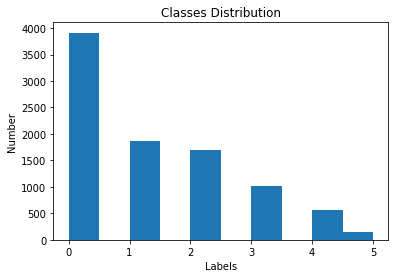

In [35]:
# Result visualization 

plt.hist(preds)
plt.xlabel('Labels')
plt.ylabel('Number')
plt.title('Classes Distribution')
plt.show()

In [36]:
sub = pd.read_csv('submission.csv')
sub['prediction'] = preds
sub.to_csv('submission_bert_3_epochs.csv', index=False)